## Template matching


* The template matching method uses a distance metric (e.g *normalized cross-correlation*) to match a template to multi-channel image. 
* The output of the method is an intensity image, where each pixel value computed by the distance metric.
* In practice, you can crop a single object of interest (e.g a cell) and predict where other such similar objects are in the image.
* Not rotation invariant, so it performs better four approximately rounded objects in a relatively consistent direction.

In [1]:
import numpy as np
from scipy.signal import correlate2d

### Method 0: Direct 2D correlation of the image with the template

$$y[m,n] = \sum_{k,l} h[k,l]x[m+k,n+l]$$

In [2]:
def match_template_corr( x , temp ):
    y = np.empty(x.shape)
    y = correlate2d(x,temp,'same')
    return y

### Method 1: Direct 2D correlation of the image with the *zero-mean* template

$$y[m,n] = \sum_{k,l} (h[k,l]-\bar{h}) x[m+k,n+l]$$

In [3]:
def match_template_corr_zmean( x , temp ):
    return match_template_corr(x , temp - temp.mean())

### Method 2: SSD

$$y[m,n] = \sum_{k,l} (h[k,l]- x[m+k,n+l])^2 $$
$$= \sum_{k,l}h[k,l]^2 - 2\sum_{k,l}h[k,l]x[m+k,n+l] + \sum_{k,l}x[m+k,n+l]^2 $$

In [4]:
def match_template_ssd( x , temp ):
    term1 = np.sum( np.square( temp ))
    term2 = -2*correlate2d(x, temp,'same')
    term3 = correlate2d( np.square( x ), np.ones(temp.shape),'same' )
    ssd = np.maximum( term1 + term2 + term3 , 0 )
    return 1 - np.sqrt(ssd)

### Method 3: Normalized cross-correlation


$$\gamma[\color{BlueViolet}{u,v}] = \frac{\sum_{x,y} (f[x,y]-\bar{f_{u,v}}) (t[\color{Red}{x-u,y-v}] - \bar{t})}{ \sqrt{\sum_{x,y}(f[x,y]-\bar{f_{u,v}})^2 \sum_{x,y}(t[\color{Red}{x-u,y-v}] - \bar{t})^2 }}$$

![](media/xcorr.png)

In the above image $u=2$, $v=4$, $x \in \{1,2,3\}$, and $y \in \{3,4,5\}$

In [5]:
def match_template_xcorr( f , t ):
    f_c = f - correlate2d( f , np.ones(t.shape)/np.prod(t.shape), 'same') 
    t_c = t - t.mean()
    numerator = correlate2d( f_c , t_c , 'same' )
    d1 = correlate2d( np.square(f_c) , np.ones(t.shape), 'same')
    d2 = np.sum( np.square( t_c ))
    denumerator = np.sqrt( np.maximum( d1 * d2 , 0 )) # to avoid sqrt of negative
    response = np.zeros( f.shape )
    valid = denumerator > np.finfo(np.float32).eps # mask to avoid division by zero
    response[valid] = numerator[valid]/denumerator[valid]
    return response

### Example on a practical application of template matching

In [6]:
# !pip install interactivecrop --user
# !pip install tabulate --user
# !pip install  opencv-python --user
#! pip install itk --user
# !pip install itkwidgets --user
# !pip install itk-io
import itk

from itkwidgets import view
import itkwidgets
from IPython.display import display

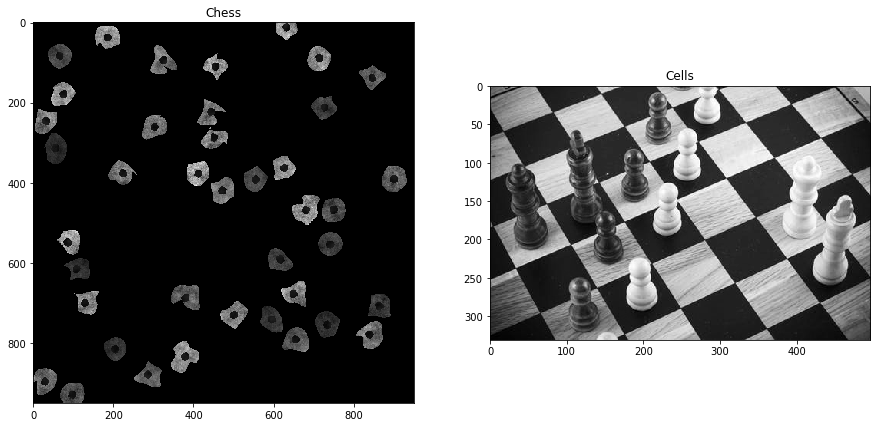

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from os.path import isfile , join
from PIL import Image
from cvutils import rgb2gray
import cv2
%matplotlib inline

imgs_dir = 'images'
imgs_names = ['ProcessPlateSparse_wA03_s08_z1_t1_CELLMASK.png','chess.jpg']
imgs_fnames = [ join( imgs_dir, img_name) for img_name in imgs_names ]
imgs_rgb = [ np.array(Image.open(img)) for img in imgs_fnames ]
imgs_gray = [ rgb2gray( img ) for img in imgs_rgb ]

fig, ax = plt.subplots(1,2,figsize = (15, 10))
ax[1].set_title('Cells')
ax[0].imshow(imgs_gray[0], cmap = 'gray')
ax[0].set_title('Chess')
ax[1].imshow(imgs_gray[1], cmap = 'gray')

In [9]:
viewers = [ view(img,annotations=False, ui_collapsed=True) for img in imgs_gray]
for viewer in viewers:
    display( viewer )


Viewer(annotations=False, geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.…

Viewer(annotations=False, geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.…

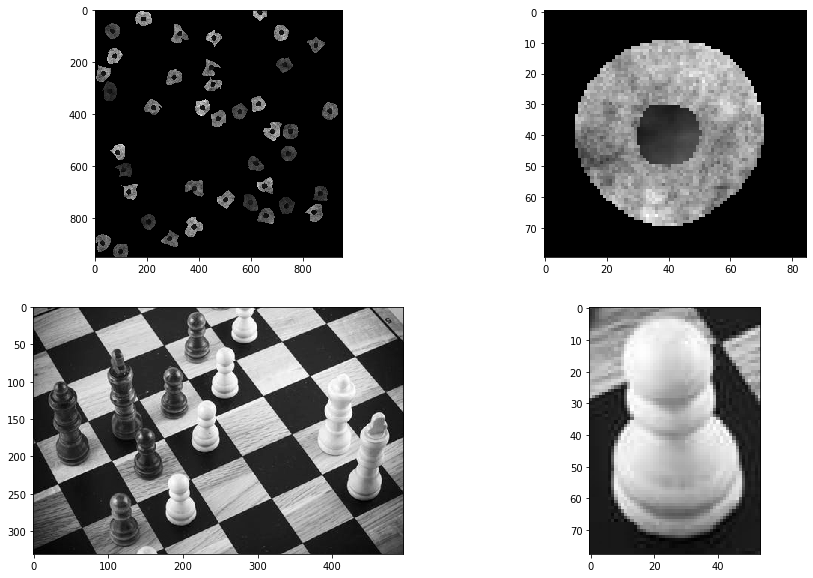

In [10]:
templates = [ img[viewer.roi_slice()] for img,viewer in zip(imgs_gray,viewers)]

fig, ax = plt.subplots(len(imgs_gray),2,figsize = (15, 10))
plt.autoscale(True)
for i,(im,temp) in enumerate(zip(imgs_gray,templates)):
    ax[i,0].imshow(im, cmap = 'gray')
    ax[i,1].imshow(temp, cmap = 'gray')
plt.show()

In [11]:
matches_corr = [ match_template_corr(x,h) for (x,h) in zip(imgs_gray,templates)]

In [12]:
matches_corr_zmean = [ match_template_corr_zmean(x,h) for (x,h) in zip(imgs_gray,templates)]

In [13]:
matches_ssd = [ match_template_ssd(x,h) for (x,h) in zip(imgs_gray,templates)]

In [14]:
matches_xcorr = [ match_template_xcorr(x,h) for (x,h) in zip(imgs_gray,templates)]

In [15]:
%reload_ext autoreload
%autoreload 2
import nms
import importlib
importlib.reload(nms)

<module 'nms' from '/home/asem/GP/sbme-tutorials.github.io/2020/cv/notebooks/nms.py'>

In [16]:
matches_corr_maxima = [ nms.local_maxima(x,min(t.shape)//8) for (x,t) in zip(matches_corr,templates)]


In [17]:
matches_corr_zmean_maxima = [ nms.local_maxima(x,min(t.shape)//8) for (x,t) in zip(matches_corr_zmean,templates)]


In [18]:
matches_ssd_maxima = [ nms.local_maxima(x,min(t.shape)) for (x,t) in zip(matches_ssd,templates)]


In [19]:
matches_xcorr_maxima = [ nms.local_maxima(x,min(t.shape)//8) for (x,t) in zip(matches_xcorr,templates)]

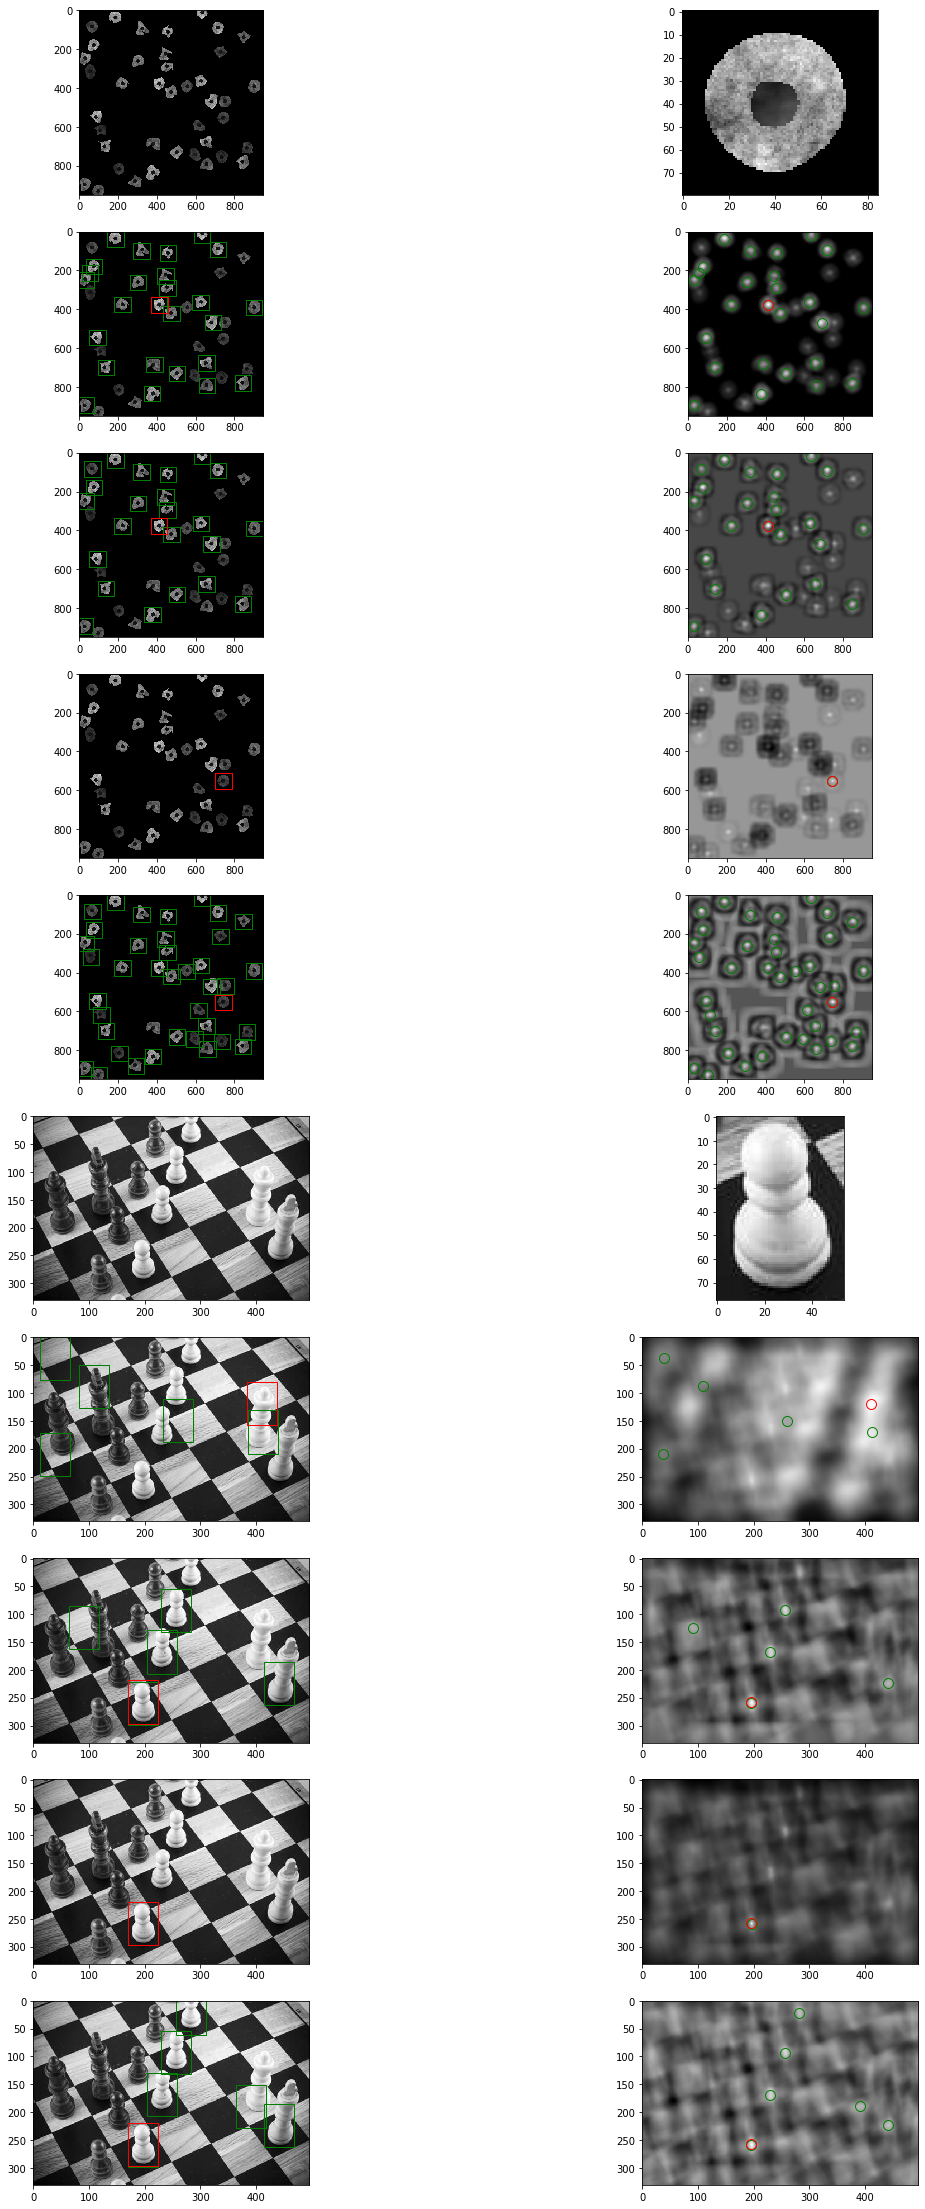

In [23]:
methods_n = 4
patches = zip(imgs_gray,templates,
              matches_corr,matches_corr_zmean,matches_ssd,matches_xcorr,
             matches_corr_maxima,matches_corr_zmean_maxima,matches_ssd_maxima,matches_xcorr_maxima)

fig, ax = plt.subplots(len(imgs_gray)*(methods_n+1),2,figsize = (20, 40))
plt.autoscale(True)
for i,(im,temp,mcorr,mcorrz,mssd,mxcorr,pcorr,pcorrz,pssd,pxcorr) in enumerate(patches):
    def get_rect_on_maximum(y,template):
        ij = np.unravel_index(np.argmax(y), y.shape)
        x, y = ij[::-1]
        # highlight matched region
        htemp, wtemp = template.shape
        rect = plt.Rectangle((x-wtemp/2, y-htemp/2), wtemp, htemp, edgecolor='r', facecolor='none')
        return rect,x,y
    
    def make_rects(plt_object,xy,template):
        htemp, wtemp = template.shape
        for ridx in range(xy.shape[0]):
            y,x = xy[ridx]
            r =  plt.Rectangle((x-wtemp/2, y-htemp/2), wtemp, htemp, edgecolor='g', facecolor='none')
            plt_object.add_patch(r)
    
    def make_circles(plt_object,xy,template):
        htemp, wtemp = template.shape
        for ridx in range(xy.shape[0]):
            y,x = xy[ridx]
            plt_object.plot(x, y, 'o', markeredgecolor='g', markerfacecolor='none', markersize=10)
            
    row = (methods_n+1)*i 
    ax[row,0].imshow(im, cmap = 'gray')
    ax[row,1].imshow(temp, cmap = 'gray')
    
    ax[row+ 1,0].imshow(im, cmap = 'gray')
    r,x,y = get_rect_on_maximum(mcorr,temp)
    make_rects( ax[row + 1,0] , pcorr, temp )
    ax[row + 1,0].add_patch(r)
    ax[row + 1,1].imshow(mcorr, cmap = 'gray')
    make_circles(ax[row + 1,1], pcorr,temp)
    ax[row + 1,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    
    r,x,y = get_rect_on_maximum(mcorrz,temp)
    ax[row + 2,0].imshow(im, cmap = 'gray')
    make_rects( ax[row + 2,0] , pcorrz, temp )
    ax[row + 2,0].add_patch(r)
    ax[row + 2,1].imshow(mcorrz, cmap = 'gray')
    make_circles(ax[row + 2,1], pcorrz,temp)
    ax[row + 2,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

    
    r,x,y = get_rect_on_maximum(mssd,temp)
    ax[row + 3,0].imshow(im, cmap = 'gray')
    make_rects( ax[row + 3,0] , pssd, temp )
    ax[row + 3,0].add_patch(r)
    ax[row + 3,1].imshow(mssd, cmap = 'gray')
    make_circles(ax[row + 3,1], pssd,temp)
    ax[row + 3,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)
    
    r,x,y = get_rect_on_maximum(mxcorr,temp)
    ax[row + 4,0].imshow(im, cmap = 'gray')
    make_rects( ax[row + 4,0] , pxcorr, temp )
    ax[row + 4,0].add_patch(r)
    ax[row + 4,1].imshow(mxcorr, cmap = 'gray')
    make_circles(ax[row + 4,1], pxcorr,temp)
    ax[row + 4,1].plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()